In [1]:
%config IPCompleter.greedy=True

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import variational_autoencoder as vae

print("Tensor Flow version {}".format(tf.__version__))

D:\z_outsourced_programs\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Tensor Flow version 1.8.0


In [3]:
#test utils
import weapon_data as weapons

def print_decoded_tensors_as_dict(weapon_data, array_of_tensors):
    genDict = {}
    
    for tensor in array_of_tensors:
        decoded = weapon_data.decode_processed_tensor(tensor)
        
        for key, value in decoded.items():
            if key not in genDict:
                genDict[key] = []
            genDict[key].append(value)
    
    for key, value in genDict.items():
            print(key, "=", value)
            
def get_weapon_data():
    return weapons.get_data(3, 12, 1)

In [4]:
import weapon_data as weapons

network_architecture = \
    dict(n_input=0, #set it in with scope
         n_hidden_1=14,
         n_hidden_2=15,
         n_z=2)  

learning_rate = 0.01
optimizer =  tf.train.AdamOptimizer(learning_rate)
#optimizer = tf.train.RMSPropOptimizer(learning_rate)
transfer_fct = lambda x : tf.nn.tanh(x)
num_epochs = 10
batch_size = 1
epoch_debug_step = 1
    
with tf.Session() as sess:
    train_data, test_data = get_weapon_data()
    network_architecture['n_input'] = train_data.num_features
  
    network = vae.get_new_trained(sess, train_data, network_architecture, optimizer, 
                              transfer_fct, batch_size, num_epochs, epoch_debug_step)


Epoch:0001, cost=20.717042397
Epoch:0002, cost=18.930967079
Epoch:0003, cost=17.893179747
Epoch:0004, cost=18.306495682
Epoch:0005, cost=17.561746969
Epoch:0006, cost=16.583086491
Epoch:0007, cost=15.615442494
Epoch:0008, cost=15.900552633
Epoch:0009, cost=15.138237557
Epoch:0010, cost=15.732622481
Trained model saved! You can find it in './trained_vae/model.ckpt'


In [5]:
with tf.Session(graph=tf.Graph()) as sess:
    network = vae.get_untrained(sess, network_architecture, optimizer, transfer_fct, batch_size)
    network = vae.restore(network, "trained_vae/model.ckpt")
        
    train_data, test_data = get_weapon_data()
    samples = test_data.next_batch(1)
    x_reconstructed = network.encode_and_decode(samples)
    
    print(samples)
    print(x_reconstructed)
    
    print_decoded_tensors_as_dict(test_data, np.concatenate((samples,x_reconstructed), axis=0))

INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt
[[ 1.95776754  0.82948142  0.60118691  2.88712045  0.99569425 -1.04880885
   1.58113883 -0.48507125 -1.32959555  0.82220467 -0.26424317  0.4513875
  -0.57240795 -0.48010721 -0.97777561 -0.32444284 -0.32444284 -0.48507125
   1.78885438 -0.32444284 -0.40824829 -0.55901699]]
[[-0.08357885 -0.3330724  -0.53984284  0.7589774  -0.42916352 -0.6136223
   1.2020075  -0.6658957  -0.29116854 -0.41067845 -0.25938237 -0.3398904
  -0.38926795 -0.20624314 -0.06887741  0.19557054  0.15808678  0.5067452
   0.6693957  -0.38606325 -0.72785664 -0.30920857]]
damages_first = ['53.0', '30.141502326732397']
damages_last = ['38.0', '15.834518328383197']
dmg_distances_first = ['66.0', '29.48326720199153']
dmg_distances_last = ['89.0', '38.17700579502957']
firemode_Automatic = ['0.0', '0.21734642579450958']
firemode_Semi-Automatic = ['1.0', '0.828725938025202']
hiprecoildec = ['3.0', '5.05494805665736']
hiprecoilright = ['0.8999999761581421', '0.42

INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt


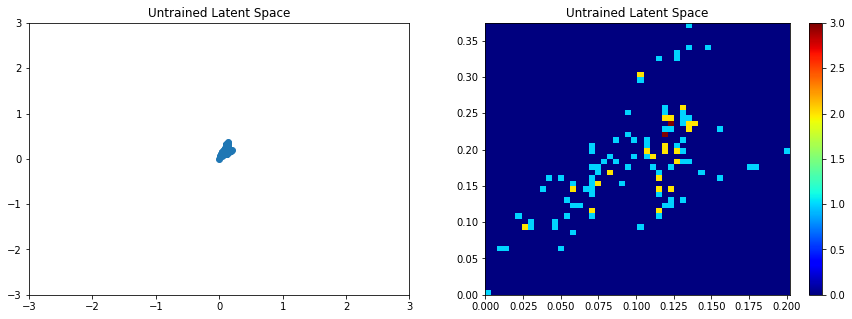

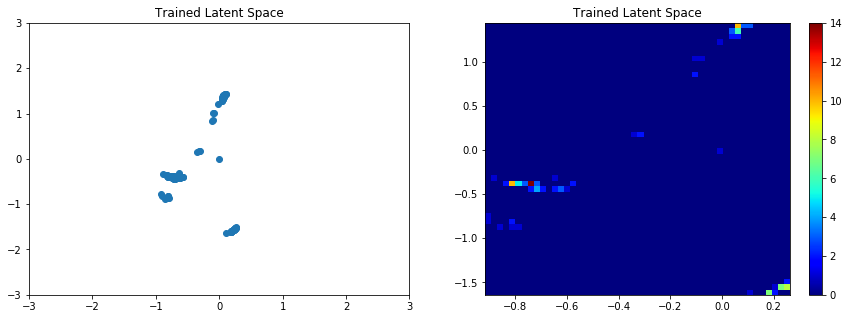

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_z_distribution(vae_model, title, z_mean=True):
    all_z = np.zeros((1,network_architecture['n_z']))
        
    train_data, test_data = get_weapon_data()
    total_batch = int(train_data.num_examples / batch_size) 

    # Loop over all batches
    for i in range(total_batch):
        batch = train_data.next_batch(batch_size)
        z_dist = vae_model.calculate_z(batch)
        if z_mean:
            z_dist = vae_model.calculate_z_mean(batch)
        all_z = np.vstack((all_z, z_dist))

    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.scatter(all_z[:,0], all_z[:,1])
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    plt.title(title)
    plt.subplot(1,2,2)
    plt.hist2d(all_z[:,0], all_z[:,1], (50, 50), cmap=plt.cm.jet)
    plt.colorbar()
    plt.title(title)
    
with tf.Session(graph=tf.Graph()) as sess:
    network = vae.get_untrained(sess, network_architecture, optimizer, transfer_fct, batch_size)
    show_z_distribution(network, "Untrained Latent Space", z_mean=True)
    network = vae.restore(network, "trained_vae/model.ckpt")
    show_z_distribution(network, "Trained Latent Space", z_mean=True)

In [7]:
# Testing
with tf.Session(graph=tf.Graph()) as sess:
    network = vae.get_untrained(sess, network_architecture, optimizer, transfer_fct, batch_size)
    network = vae.restore(network, "trained_vae/model.ckpt")
    
    generated = []
    for i in range(4):
        random_val = np.random.normal(size=(1,network_architecture["n_z"]))
        x_test = network.decode_from_latent_space(random_val)
        generated.append(x_test[0])
        
    train_data, test_data = get_weapon_data()
    print_decoded_tensors_as_dict(train_data, generated)

INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt
damages_first = ['29.559306383726266', '47.24076211266206', '30.00478807533316', '78.07163799824838']
damages_last = ['17.817328785989112', '31.164304650875398', '17.581934256917428', '64.11245713472117']
dmg_distances_first = ['19.12340102621512', '21.879909291205692', '20.02458900736641', '10.196637817273537']
dmg_distances_last = ['42.0451089023843', '63.048155607498934', '42.050880720853456', '109.99260754160268']
firemode_Automatic = ['0.4863700359871784', '0.030459255208517555', '0.43432524791154525', '0.03894804115043893']
firemode_Semi-Automatic = ['0.5748888680150802', '0.759622205054547', '0.6284977976473016', '0.17525395971904936']
hiprecoildec = ['6.322396564062193', '4.452514025086625', '6.1154903976841055', '4.277460242871096']
hiprecoilright = ['0.3759521371687695', '0.5599932049422993', '0.37995955654072733', '0.8619962259797394']
hiprecoilup = ['1.179458687678575', '2.792419350794406', '1.2554123133210342